In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import unicodedata
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from collections import defaultdict
# %matplotlib inline

In [2]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
global color_h, color_f, color_b, PLOTDIM, FREQYEARS
color_h = "gold"
color_f = "royalblue"
color_b = "lightgray"
PLOTDIM = (9,6)
FREQYEARS = 10
my_cm = LinearSegmentedColormap.from_list("colormap", [color_h, color_f], N=100)

In [3]:
matplotlib.font_manager._rebuild()
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.sans-serif'] = 'Roboto'
plt.rcParams['font.weight'] = 500
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

In [230]:
def linearize(str1):
    d = [str1[0]] + [str1[i] for i in range(1,len(str1)) if str1[i-1] != str1[i]]
    return ''.join(d)

In [4]:
# Les données sont stockées dans le dossier "data", c'est plus clean
raw_authors = pd.read_csv('../data/ALL_AUTHORS (live_work + clean nat).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art = pd.read_csv('../data/ALL_ARTWORKS (for stats use ONLY).csv', encoding='utf-8', sep=',', low_memory=False)
raw_art['groupcol'] = raw_art['related'].fillna(value='') + raw_art['acquisition'].fillna(value='')

In [5]:
# On fusionne les "séries"
art = raw_art.groupby(['groupcol', 'authors', 'acquisition_year', 'acquisition_mode_clean']).first().reset_index()
art = art[art['acquisition_year'] > 1945]
raw_authors['live_and_work'] = raw_authors['live_and_work'].replace({'0': None})
print(art.shape, raw_authors.shape)

(83915, 117) (35958, 23)


In [6]:
# art['collection'].value_counts()

In [7]:
art = art[pd.notnull(art['collection'])]
art['collection_category'] = None
for i, row in art.iterrows():
    museum = row['collection']
    if "frac" in museum.lower():
        cat = 'F'
    elif "musée national d'art moderne" in museum.lower():
        cat = 'P'
    elif "centre national des arts plastiques" in museum.lower():
        cat = 'C'
    elif "musée" in museum.lower():
        cat = 'M'
    else:
        cat = 'A'
    art.at[i, 'collection_category'] = cat

In [8]:
art['collection_category'].value_counts()

C    22554
M    21887
P    16556
A    11430
F    11057
Name: collection_category, dtype: int64

In [9]:
count = -1
for i, row in raw_authors.iterrows():
    count += 1
    if count % 5000 == 0:
        print(round(100*count/len(raw_authors)), '%')
    ind = row['Id artist']
    a = art[art['authors'].str.contains(str(ind))].sort_values('acquisition_year')
    raw_authors.at[i, 'acquisition_year'] = '|'.join([str(int(x)) for x in a['acquisition_year'].values])
    raw_authors.at[i, 'sequence'] = ''.join([x for x in a['collection_category'].values])

0 %
14 %
28 %
42 %
56 %
70 %
83 %
97 %


In [10]:
raw_authors['acquisition_year'] = raw_authors['acquisition_year'].replace({'': None})

In [14]:
raw_authors['first_aquisition'], raw_authors['last_aquisition_alive'] = None, None
for i, row in raw_authors.iterrows():
    dates = row['acquisition_year']
    if not pd.isnull(dates):
        dates = [int(d) for d in re.split('\|', dates)]
        raw_authors.at[i, 'art_count'] = len(dates)
        raw_authors.at[i, 'first_aquisition'] = min(dates)
        if not pd.isnull(row['Death year']):
            dates = [d for d in dates if d <= row['Death year']]
        if len(dates) > 0:
            raw_authors.at[i, 'last_aquisition_alive'] = max(dates)

In [12]:
# raw_authors['art_count'].value_counts()

In [239]:
authors = raw_authors[raw_authors['art_count'] >= 5]
authors = authors[authors['first_aquisition'] >= 1945]

In [240]:
for i, row in authors.iterrows():
    if pd.isnull(row['last_aquisition_alive']):
        authors.at[i, 'dead_career'] = 0
    elif (2018 - row['Birth year'] > 65) and (row['last_aquisition_alive'] < 2000):
        authors.at[i, 'dead_career'] = 1
    else:
        authors.at[i, 'dead_career'] = 2

In [241]:
# Count of alive but dead career artists
((authors['dead_career'] == 1) & pd.isnull(authors['Death year'])).sum()

447

In [242]:
authors = authors[pd.notnull(authors['Death year']) | (authors['dead_career'] == 1)]

In [243]:
# Dead or deed-career artists
len(authors)

2403

In [244]:
(authors['Death year'] - authors['Birth year']).mean()

76.63343558282209

In [245]:
# authors.to_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')
# authors = pd.read_csv("../data/DEAD AUTHORS (broadly).csv", encoding='utf-8', sep=',')

In [246]:
authors['linlength'] = authors['sequence'].apply(linearize).apply(len)

In [247]:
authors = authors[authors['linlength'] < 50]

### LEVENSTEIN DIST

In [256]:
SUB_COST = 2
DEL_COST = 1
INS_COST = 1

In [303]:
def insertion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [304]:
def deletion_cost(i, j, str1, str2):
    if i == 1:
        return 1
    elif i-2 <= 0:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    else:
        return 1

In [305]:
def substitution_cost(i, j, str1, str2):
    if str1[i-1] == str2[j-1]:
        return 0
    elif i == 1:
        return 1
    elif str2[j-1] == str1[i-2]:
        return 0.5
    elif i >= len(str1):
        return 1
    elif str2[j-1] == str1[i]:
        return 0.5
    else:
        return 1

In [315]:
def levenshtein(str1, str2):
    # en fait, Wagner–Fischer algorithm
    # http://www.inrg.csie.ntu.edu.tw/algorithm2014/homework/Wagner-74.pdf
    # str1 = linearize(str1)
    # str2 = linearize(str2)
    n = len(str1)
    m = len(str2)
    d = np.zeros((n+1, m+1))
    for i in range(n+1):
        d[i,0] = i
    for j in range(m+1):
        d[0,j] = j
    for i in range(1,n+1):
        for j in range(1,m+1):
            if str1[i-1] == str2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(
                    d[i  ,j-1] + insertion_cost(i, j, str1, str2),    # Deletion cost
                    d[i-1,j  ] + deletion_cost(i, j, str1, str2),     # Insertion cost
                    d[i-1,j-1] + substitution_cost(i, j, str1, str2)) # Substition cost
    ldist = d[n,m] / max(n, m)
    return ldist

In [316]:
ARTISTS_SEQUENCES = dict()
for i, row in authors.iterrows():
    ARTISTS_SEQUENCES[row['Id artist']] = row['sequence']

In [ ]:
ARTISTS = list(ARTISTS_SEQUENCES.keys())
distance = np.zeros((len(ARTISTS_SEQUENCES), len(ARTISTS_SEQUENCES)))

for i, artist_source in enumerate(ARTISTS):
    if i % 500 == 0:
        print(round(100*i/len(ARTISTS_SEQUENCES)), '%')
    sequence_source = ARTISTS_SEQUENCES[artist_source]

    for j in range(i+1, len(ARTISTS)):
        artist_target = ARTISTS[j]
        sequence_target = ARTISTS_SEQUENCES[artist_target]

        d = levenshtein(sequence_source, sequence_target)
        distance[i, j] = d
        distance[j, i] = d

0 %


In [ ]:
# 4) Deriving clusters
NUM_CLUSTERS = 5
kmeans = cluster.KMeans(NUM_CLUSTERS, random_state=1234).fit(distance)
labels = kmeans.labels_

In [ ]:
def plot_clusters(dataset, labels):
    fig, ax = plt.subplots(figsize=(7,7))

    reduced_data = PCA(n_components=2, random_state=123).fit_transform(dataset)
    x_min, x_max = reduced_data[:, 0].min() - .1, reduced_data[:, 0].max() + .1
    y_min, y_max = reduced_data[:, 1].min() - .1, reduced_data[:, 1].max() + .1

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
    # for i in range(len(reduced_data)): plt.annotate(dataset.index.tolist()[i], reduced_data[i])

    # centroids = kmeans.cluster_centers_
    # plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    # plt.xlim(x_min, x_max)
    # plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

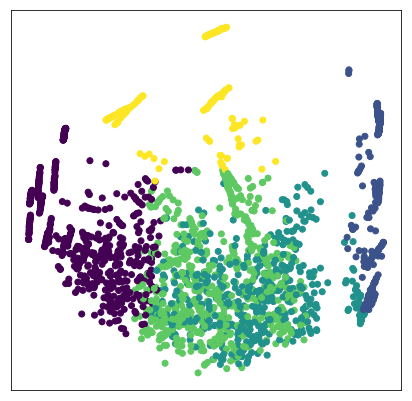

In [311]:
plot_clusters(distance, labels)

In [314]:
i = 3
print('Cluster n°%i containing:' % (i + 1))

for j, artist in enumerate(ARTISTS):
    if labels[j] == i:
        sequence = ARTISTS_SEQUENCES[artist]
        print('  - %s (%s)' % (artist, sequence))

Cluster n°4 containing:
  - 9000000000065788 (PPMMFMC)
  - 9000000000065799 (CCMCPPMMCM)
  - 9000000000065806 (PPCCCCCMMCPMMMMMP)
  - 9000000000072443 (CMAAMM)
  - 9000000000071621 (CCCCCCCCCCMPP)
  - 9000000000068101 (MCPMMMCFMA)
  - 9000000000065815 (CCCMMCMPMM)
  - 9000000000065816 (PPPPPACMCPP)
  - 9000000000068922 (CCCFC)
  - 9000000000065822 (APCPP)
  - 9000000000066208 (PPCPP)
  - 9000000000075531 (MMCCP)
  - 9000000000085364 (FPMCC)
  - 9000000000065826 (MMMMACPMMCPCMPPPPP)
  - 9000000000065830 (CCCCMM)
  - 9000000000065831 (MCPPMPPCCP)
  - 9000000000072448 (AAMAAAA)
  - 9000000000065837 (AMMAAAAAA)
  - 9000000000068984 (CCMMCC)
  - 9000000000065838 (AAPMACMAP)
  - 9000000000065839 (CCPCAMM)
  - 9000000000067565 (CPCFCFF)
  - 9000000000065694 (CPMMP)
  - 9000000000065798 (ACCCCMMMMAMMPAM)
  - 9000000000077149 (MCMMAMMAAM)
  - 9000000000069005 (CMCFFF)
  - 9000000000069008 (ACCCCMC)
  - 9000000000080287 (CMFFFFFFF)
  - 9000000000071336 (MCMCCCCC)
  - 9000000000071183 (FMAFFAAA)
